In [1]:
import pandas as pd
import numpy as np
import random
from transformers import pipeline
import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1. Game Context Setup: Map the columns of your dataframe to the modified battleship game rules.
- Columns like bin, type, paras, etc., can be associated with specific game states or parameters.
2. Question Evaluation: Use the text or full column as questions generated by LLMs or humans, and evaluate their quality using Expected Information Gain (EIG).
3. Integration with Metrics: Compute metrics like EIG for each question in the dataframe and add a new column for these scores.
4. Comparison: Analyze the scores to compare human-generated vs. LLM-generated questions.

In [165]:
df = pd.read_csv('data/df.allBySubj.csv')
df.head()

,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text
0,1,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?
1,2,7,horizontal(purple),horizontal,3,3.0,NaN,NaN,Is the purple ship horizontal?,Is the purple ship laying horizontal?
2,3,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?
3,4,7,horizontal(blue),horizontal,1,1.0,NaN,NaN,Is the blue ship horizontal?,Is the blue ship vertical
4,5,7,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,How many blocks is the purple ship?


In [156]:
df.describe(include='all')

,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text
count,605.000000,605.000000,605,605,578,578.000000,204.000000,31.000000,605,605
unique,NaN,NaN,139,35,58,NaN,NaN,NaN,139,395
top,NaN,NaN,shipsize(red),shipsize,2,NaN,NaN,NaN,How many tiles is the red ship?,How long is the red ship?
freq,NaN,NaN,66,185,129,NaN,NaN,NaN,66,14
mean,9.570248,51.008264,NaN,NaN,NaN,2.271626,2.867647,1.967742,NaN,NaN
std,5.205108,19.788993,NaN,NaN,NaN,1.273891,1.330629,0.795147,NaN,NaN
min,1.000000,7.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN
25%,5.000000,39.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000,NaN,NaN
50%,9.000000,57.000000,NaN,NaN,NaN,2.000000,3.000000,2.000000,NaN,NaN
75%,14.000000,67.000000,NaN,NaN,NaN,3.000000,4.000000,3.000000,NaN,NaN


# Setting up the game environment
Create a grid-based battleship game with modified rules.

In [104]:
# Battleship game setup
class BattleshipGame:
    def __init__(self, grid_size=6, ships=None):
        self.grid_size = grid_size
        self.grid = np.zeros((grid_size, grid_size))
        self.ships = ships if ships else self._generate_ships()

    def _generate_ships(self):
        # Example predefined ships (can be randomized as needed)
        ships = [
            {'color': 'red', 'length': 3, 'orientation': 'horizontal', 'start': (1, 2)},
            {'color': 'blue', 'length': 2, 'orientation': 'vertical', 'start': (4, 1)},
            {'color': 'purple', 'length': 4, 'orientation': 'horizontal', 'start': (5, 0)},
        ]
        for ship in ships:
            x, y = ship['start']
            for i in range(ship['length']):
                if ship['orientation'] == 'horizontal':
                    self.grid[x, y + i] = 1
                else:
                    self.grid[x + i, y] = 1
        return ships

    def query_tile(self, x, y):
        return "hit" if self.grid[x, y] == 1 else "miss"
    
    def display_game_status(self):
        """Display the current game status in grid format."""
        display_grid = []
        for row in self.grid:
            display_row = [0 if cell == 0 else 1 for cell in row]
            display_grid.append(display_row)
        return [np.array(display_grid)]

# Initialize the game
game = BattleshipGame()


In [118]:
def convert_trials_to_matrix(file_path):
    """
    Convert trials stored in a .txt file to a 2D matrix.

    Parameters:
        file_path (str): Path to the .txt file containing the trials.

    Returns:
        np.ndarray: 2D matrix representation of the trials, where H and W are mapped to 0, and B, R, P are mapped to 1.
    """
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

    matrix = []
    for line in lines:
        row = line.strip().split(',')
        matrix.append(row)

    return np.array(matrix)

In [119]:
convert_trials_to_matrix('data/board_1.txt')

array([['H', 'H', 'H', 'H', 'W', 'H'],
       ['H', 'H', 'W', 'H', 'H', 'H'],
       ['H', 'H', 'H', 'W', 'H', 'H'],
       ['W', 'H', 'H', 'H', 'H', 'H'],
       ['H', 'H', 'H', 'W', 'H', 'H'],
       ['H', 'H', 'H', 'H', 'W', 'H']], dtype='<U1')

In [120]:
def count_ship_lengths(matrix):
    """
    Count the length of each ship in a 2D matrix.

    Parameters:
        matrix (np.ndarray): 2D matrix representing the game board.

    Returns:
        dict: Dictionary with ship types (R, B, P) as keys and their lengths as values.
    """
    ship_lengths = {"R": 0, "B": 0, "P": 0}

    # Check horizontal lengths
    for row in matrix:
        current_ship = None
        length = 0
        for cell in row:
            if cell in ship_lengths:
                if cell == current_ship:
                    length += 1
                else:
                    if current_ship:
                        ship_lengths[current_ship] = max(ship_lengths[current_ship], length)
                    current_ship = cell
                    length = 1
            else:
                if current_ship:
                    ship_lengths[current_ship] = max(ship_lengths[current_ship], length)
                current_ship = None
                length = 0
        if current_ship:
            ship_lengths[current_ship] = max(ship_lengths[current_ship], length)

    # Check vertical lengths
    for col in range(matrix.shape[1]):
        current_ship = None
        length = 0
        for row in range(matrix.shape[0]):
            cell = matrix[row, col]
            if cell in ship_lengths:
                if cell == current_ship:
                    length += 1
                else:
                    if current_ship:
                        ship_lengths[current_ship] = max(ship_lengths[current_ship], length)
                    current_ship = cell
                    length = 1
            else:
                if current_ship:
                    ship_lengths[current_ship] = max(ship_lengths[current_ship], length)
                current_ship = None
                length = 0
        if current_ship:
            ship_lengths[current_ship] = max(ship_lengths[current_ship], length)

    return ship_lengths

In [159]:
hypothesis_space = []
for i in range(1,19):
    hypothesis_space.append(convert_trials_to_matrix('data/board_{}.txt'.format(i)))

In [125]:
hypothesis_space[1]

array([['H', 'H', 'H', 'H', 'H', 'H'],
       ['H', 'H', 'W', 'H', 'W', 'H'],
       ['H', 'H', 'P', 'H', 'H', 'H'],
       ['H', 'H', 'H', 'W', 'H', 'H'],
       ['H', 'W', 'H', 'H', 'H', 'H'],
       ['H', 'H', 'H', 'H', 'W', 'H']], dtype='<U1')

In [126]:
count_ship_lengths(hypothesis_space[1])

{'R': 0, 'B': 0, 'P': 1}

In [87]:
# Generate hypothesis space
def generate_hypothesis_space(grid_size=6, num_hypotheses=100):
    """
    Generate a list of random grid configurations representing possible game states.
    """
    return [np.random.randint(0, 2, size=(grid_size, grid_size)) for _ in range(num_hypotheses)]

#hypothesis_space = generate_hypothesis_space()
#hypothesis_space


In [105]:
hypothesis_space = game.display_game_status()
hypothesis_space

[array([[0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0]])]

# Bayesian Ideal Observer Model
Implement the ideal observer to calculate the expected information gain (EIG) for each possible question.

In [173]:
from scipy.stats import entropy

# Function to calculate EIG

def calculate_eig(hypothesis_space, question_function):
    """
    Calculate Expected Information Gain (EIG) for a given question.
    """
    # Prior probabilities (uniform distribution)
    prior_probs = np.ones(len(hypothesis_space)) / len(hypothesis_space)

    # Simulate answers for the given question
    answers = question_function(hypothesis_space)

    # Ensure answers are scalar or properly converted
    answers = [a.tolist() if isinstance(a, np.ndarray) else a for a in answers]
    unique_answers = np.unique(answers)

    # Calculate posterior probabilities
    posterior_probs = []
    for answer in unique_answers:
        likelihood = np.array([1 if np.array_equal(a, answer) else 0 for a in answers])
        posterior = likelihood * prior_probs
        posterior /= posterior.sum() if posterior.sum() > 0 else 1  # Avoid division by zero
        posterior_probs.append(posterior)

    # Calculate entropy
    prior_entropy = entropy(prior_probs)
    posterior_entropies = [entropy(p) for p in posterior_probs]

    # Compute EIG
    eig = prior_entropy - np.mean(posterior_entropies)
    return eig

# Dynamic Question Function
Each row in the dataframe contains a question (text) which should dynamically define the question function based on the content of the bin, type, or text column.

In [169]:
def dynamic_question_function(row):
    """
    Create a question function based on the row's content.
    """
    bin_info = row['bin']
    type_info = row['type']

    def question_function(hypothesis_space):
        answers = []
        for h in hypothesis_space:
            if type_info == "shipsize":
                if "red" in bin_info:
                    answers.append(np.sum(h == 'R'))
                elif "blue" in bin_info:
                    answers.append(np.sum(h == 'B'))
                elif "purple" in bin_info:
                    answers.append(np.sum(h == 'P'))
            elif type_info == "horizontal":
                if "red" in bin_info:
                    answers.append(bool(np.any(np.all(h == 'R', axis=1))))
                elif "blue" in bin_info:
                    answers.append(bool(np.any(np.all(h == 'B', axis=1))))
                elif "purple" in bin_info:
                    answers.append(bool(np.any(np.all(h == 'P', axis=1))))
            elif type_info == "coordinate":
                if "red" in bin_info:
                    coords = np.argwhere(h == 'R')
                elif "blue" in bin_info:
                    coords = np.argwhere(h == 'B')
                elif "purple" in bin_info:
                    coords = np.argwhere(h == 'P')
                answers.append(tuple(coords[0]) if coords.size > 0 else (0, 0))
            else:
                # Ensure default case returns a valid answer
                answers.append(0)  # Default fallback for invalid or unspecified cases
        return answers

    return question_function


In [146]:
df

,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text,EIG
0,1,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?,0.0
1,2,7,horizontal(purple),horizontal,3,3.0,NaN,NaN,Is the purple ship horizontal?,Is the purple ship laying horizontal?,0.0
2,3,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?,0.0
3,4,7,horizontal(blue),horizontal,1,1.0,NaN,NaN,Is the blue ship horizontal?,Is the blue ship vertical,0.0
4,5,7,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,How many blocks is the purple ship?,0.0
...,...,...,...,...,...,...,...,...,...,...,...
600,6,76,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,how big is the purple ship?,0.0
601,7,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue ship,0.0
602,8,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue ship?,0.0
603,9,76,shipsize(blue),shipsize,1,1.0,NaN,NaN,How many tiles is the blue ship?,how big is the blue boat,0.0


# Compute EIG for Each Question
Apply the Bayesian observer model to compute EIG for each question in the dataframe.

In [170]:
# Apply EIG calculation to the dataframe
#hypothesis_space = [hypothesis_space[2]]
def calculate_eig_for_row(row):
    """
    Calculate EIG for a given row using the dynamic question function.
    """
    question_function = dynamic_question_function(row)
    return calculate_eig(hypothesis_space, question_function)



In [171]:
df.describe(include='all')

,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text
count,610.000000,610.000000,610,610,578,578.000000,204.000000,31.000000,610,610
unique,NaN,NaN,140,36,58,NaN,NaN,NaN,144,400
top,NaN,NaN,shipsize(red),shipsize,2,NaN,NaN,NaN,How many tiles is the red ship?,How long is the red ship?
freq,NaN,NaN,67,187,129,NaN,NaN,NaN,66,14
mean,9.491803,51.237705,NaN,NaN,NaN,2.271626,2.867647,1.967742,NaN,NaN
std,5.255142,19.869217,NaN,NaN,NaN,1.273891,1.330629,0.795147,NaN,NaN
min,0.000000,7.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,NaN
25%,5.000000,39.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000,NaN,NaN
50%,9.000000,57.000000,NaN,NaN,NaN,2.000000,3.000000,2.000000,NaN,NaN
75%,14.000000,67.000000,NaN,NaN,NaN,3.000000,4.000000,3.000000,NaN,NaN


# Compare LLMs and Humans
Use the subj column to distinguish between human and LLM-generated questions and analyze the results.

Average EIG - Humans: 0.4084200578251969
Average EIG - LLMs: 0.3374690152885344


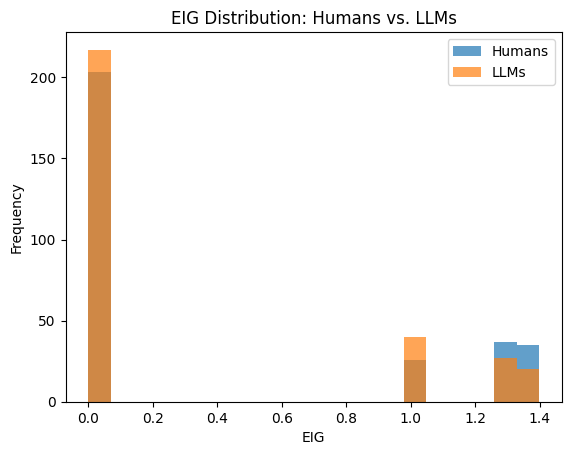

In [163]:
import matplotlib.pyplot as plt

# Separate LLM and human participants
human_df = df[df['subj'] < 57]  # Example: humans have `subj` IDs < 57
llm_df = df[df['subj'] >= 57]   # Example: LLMs have `subj` IDs >= 57

# Calculate average EIG
avg_eig_human = human_df['EIG'].mean()
avg_eig_llm = llm_df['EIG'].mean()

print(f"Average EIG - Humans: {avg_eig_human}")
print(f"Average EIG - LLMs: {avg_eig_llm}")

# Visualize the distribution of EIG
plt.hist(human_df['EIG'], alpha=0.7, label='Humans', bins=20)
plt.hist(llm_df['EIG'], alpha=0.7, label='LLMs', bins=20)
plt.title("EIG Distribution: Humans vs. LLMs")
plt.xlabel("EIG")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Enhance LLM Performance
Enhancements like fine-tuning or Chain-of-Thought prompting can be tested by generating new questions with the updated model and repeating the EIG evaluation.

In [34]:
from transformers import pipeline

# Load LLM with Chain-of-Thought prompting
llm = pipeline("text-generation", model="openai-community/gpt2")

# Define a Chain-of-Thought prompt
cot_prompt = """
You are an expert at generating strategic questions, and we are playing a grid-based battleship game consisting of ships of three colors: red, blue, purple.
If you had a special opportunity to ask any question about the grid, ships, or tiles, what would you ask?
 The only two restrictions were that combinations of questions were not allowed 
 (i.e., putting two questions together with “and” or “or”) and questions had to be answerable witha single piece of information 
 (e.g., a word, a number,true/false, or a single coordinate).

You only need to ask your question and don't repeat the prompt or give other instructions.
"""

# Generate questions with CoT
generated_questions = [llm(cot_prompt, max_length=200)[0]['generated_text'] for _ in range(5)]
print("Generated Questions with CoT:", generated_questions)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Generated Questions with CoT: ['\nYou are an expert at generating strategic questions, and we are playing a grid-based battleship game consisting of ships of three colors: red, blue, purple.\nIf you had a special opportunity to ask any question about the grid, ships, or tiles, what would you ask?\n The only two restrictions were that combinations of questions were not allowed \n (i.e., putting two questions together with “and” or “or”) and questions had to be answerable witha single piece of information \n (e.g., a word, a number,true/false, or a single coordinate).\n\nYou only need to ask your question and don\'t repeat the prompt or give other instructions.\n\nYou are free to discuss the questions.\n\nQ. What are the rules? Do I have to be a member of the game for one of them to be considered a "feature"?\n\nYes. First, there is a', "\nYou are an expert at generating strategic questions, and we are playing a grid-based battleship game consisting of ships of three colors: red, blue, p

In [35]:
for i in generated_questions:
    print(i)


You are an expert at generating strategic questions, and we are playing a grid-based battleship game consisting of ships of three colors: red, blue, purple.
If you had a special opportunity to ask any question about the grid, ships, or tiles, what would you ask?
 The only two restrictions were that combinations of questions were not allowed 
 (i.e., putting two questions together with “and” or “or”) and questions had to be answerable witha single piece of information 
 (e.g., a word, a number,true/false, or a single coordinate).

You only need to ask your question and don't repeat the prompt or give other instructions.

You are free to discuss the questions.

Q. What are the rules? Do I have to be a member of the game for one of them to be considered a "feature"?

Yes. First, there is a

You are an expert at generating strategic questions, and we are playing a grid-based battleship game consisting of ships of three colors: red, blue, purple.
If you had a special opportunity to ask any

In [ ]:
import openai
openai.api_key = ""

cot_prompt2 = """
If you had a special opportunity to ask any question about the grid, ships, or tiles, what would you ask?
 The only two restrictions were that combinations of questions were not allowed 
 (i.e., putting two questions together with “and” or “or”) and questions had to be answerable witha single piece of information 
 (e.g., a word, a number,true/false, or a single coordinate).

You only need to ask your question and don't repeat the prompt or give other instructions.
"""

generated_questions2 = []
for _ in range(5):
    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert at generating strategic questions, and we are playing a grid-based battleship game consisting of ships of three colors: red, blue, purple."},
            {"role": "user", "content": cot_prompt2}
        ],
        max_tokens=50
    )
    generated_questions2.append(response['choices'][0]['message']['content'])

print("Generated Questions with CoT:", generated_questions2)

Generated Questions with CoT: ['Which row contains the most red ship segments?', 'What is the location of the largest contiguous grouping of red ship tiles on the grid?', 'What are the coordinates of the center tile of the largest ship on the grid?', 'What is the exact coordinate of any red ship on the grid?', 'What is the length of the longest ship on the grid?']


In [31]:
for i in generated_questions2:
    print(i)

Which row contains the most red ship segments?
What is the location of the largest contiguous grouping of red ship tiles on the grid?
What are the coordinates of the center tile of the largest ship on the grid?
What is the exact coordinate of any red ship on the grid?
What is the length of the longest ship on the grid?


In [167]:
new_rows = pd.DataFrame({"trial":[0,0,0,0,0],"subj":[77,78,79,80,81], "bin":["shipsize(red)","coordinate(red)","horizontal(purple)","coordinate(red)","shipsize(blue)"],\
            "type":["shipsize","coordinate","horizontal","coordinate","shipsize"],	"paras":[None]*5, "para_1":[None]*5 ,"para_2":[None]*5, \
                "para_3":[None]*5, "full":generated_questions2, "text":generated_questions2})

df = pd.concat([df, new_rows], ignore_index=True)
df

C:\Users\alber\AppData\Local\Temp\ipykernel_17244\169547782.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_rows], ignore_index=True)


,trial,subj,bin,type,paras,para_1,para_2,para_3,full,text
0,1,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?
1,2,7,horizontal(purple),horizontal,3,3.0,NaN,NaN,Is the purple ship horizontal?,Is the purple ship laying horizontal?
2,3,7,shipsize(red),shipsize,2,2.0,NaN,NaN,How many tiles is the red ship?,How many blocks is the red ship?
3,4,7,horizontal(blue),horizontal,1,1.0,NaN,NaN,Is the blue ship horizontal?,Is the blue ship vertical
4,5,7,shipsize(purple),shipsize,3,3.0,NaN,NaN,How many tiles is the purple ship?,How many blocks is the purple ship?
...,...,...,...,...,...,...,...,...,...,...
605,0,77,shipsize(red),shipsize,None,NaN,NaN,NaN,Which row contains the most red ship segments?,Which row contains the most red ship segments?
606,0,78,coordinate(red),coordinate,None,NaN,NaN,NaN,What is the location of the largest contiguous...,What is the location of the largest contiguous...
607,0,79,horizontal(purple),horizontal,None,NaN,NaN,NaN,What are the coordinates of the center tile of...,What are the coordinates of the center tile of...
608,0,80,coordinate(red),coordinate,None,NaN,NaN,NaN,What is the exact coordinate of any red ship o...,What is the exact coordinate of any red ship o...


In [174]:
# Add EIG column to the dataframe
df['EIG'] = df.apply(calculate_eig_for_row, axis=1)

In [175]:
df.EIG.unique()

array([1.22015999, 0.        , 1.47463164, 1.83887268,        nan])

In [176]:
df.subj.unique()

array([ 7, 11, 12, 13, 17, 25, 28, 32, 37, 39, 41, 42, 47, 49, 50, 51, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81], dtype=int64)

Average EIG - Humans: 0.45627269746478044
Average EIG - LLMs: 1.0196775588960072


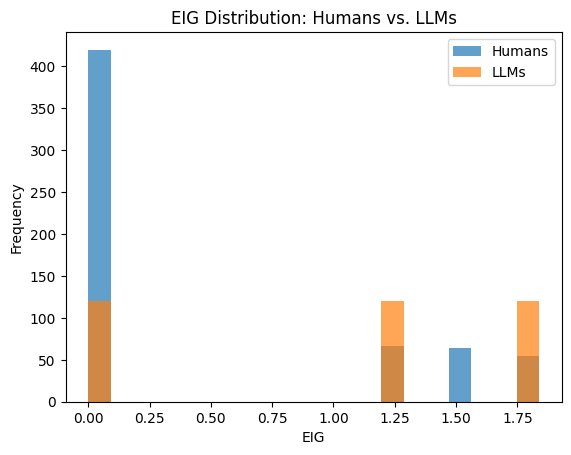

In [180]:
import matplotlib.pyplot as plt

# Separate LLM and human participants
human_df = df[df['subj'] <= 76]  # Example: humans have `subj` IDs < 57
llm_df = df[df['subj'] >= 77]   # Example: LLMs have `subj` IDs >= 57
llm_df = pd.concat([llm_df] * 120, ignore_index=True)
# Calculate average EIG
avg_eig_human = human_df['EIG'].mean()
avg_eig_llm = llm_df['EIG'].mean()

print(f"Average EIG - Humans: {avg_eig_human}")
print(f"Average EIG - LLMs: {avg_eig_llm}")

# Visualize the distribution of EIG
plt.hist(human_df['EIG'], alpha=0.7, label='Humans', bins=20)
plt.hist(llm_df['EIG'], alpha=0.7, label='LLMs', bins=20)
plt.title("EIG Distribution: Humans vs. LLMs")
plt.xlabel("EIG")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# disregard below for now

In [8]:
from transformers import RobertaTokenizer, RobertaForMaskedLM

# Load RoBERTa
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForMaskedLM.from_pretrained("roberta-base")

def generate_question(prompt):
    """
    Use RoBERTa to predict tokens for the <mask> in the input prompt.
    """
    # Ensure the input prompt contains the <mask> token
    if "<mask>" not in prompt:
        raise ValueError("The prompt must contain the <mask> token for MLM predictions.")

    # Tokenize the input prompt
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    # Get the index of the <mask> token
    mask_token_index = (input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
    if mask_token_index.size(0) == 0:
        raise ValueError("No <mask> token found in the input.")

    # Predict the token(s) to fill the <mask>
    outputs = model(input_ids)
    logits = outputs.logits
    mask_token_logits = logits[0, mask_token_index, :]

    # Get the top 5 predictions for the <mask> token
    top_5_tokens = mask_token_logits.topk(5, dim=1).indices[0].tolist()
    predicted_tokens = [tokenizer.decode([token]).strip() for token in top_5_tokens]

    return predicted_tokens

# Example usage
question_prompt = "Is the <mask> ship horizontal?"
print("Predicted completions:", generate_question(question_prompt))


Predicted completions: ['anchor', 'whole', 'entire', 'container', 'capital']


In [9]:
def calculate_eig_for_row(row, hypothesis_space):
    """
    Calculate EIG for a given row using a dynamic question function based on the row's content.
    """
    # Parse the row to extract relevant information
    bin_info = row['bin']  # Example: "shipsize(red)"
    type_info = row['type']  # Example: "shipsize"

    # Define a dynamic question function
    def question_function(hypothesis_space):
        # Example: Extract color and check a specific grid property
        if "red" in bin_info and type_info == "shipsize":
            # Example: Simulate answers about the size of the red ship
            return ["yes" if h[1, 2] == 1 else "no" for h in hypothesis_space]
        elif "blue" in bin_info and type_info == "horizontal":
            # Example: Simulate answers about the orientation of the blue ship
            return ["yes" if np.any(h[:, 3] == 1) else "no" for h in hypothesis_space]
        else:
            # Default: Check cell (2, 3) as a fallback
            return ["yes" if h[2, 3] == 1 else "no" for h in hypothesis_space]

    # Calculate EIG
    return calculate_eig(hypothesis_space, question_function)

# Apply the dynamic EIG calculation
df['EIG'] = df.apply(lambda row: calculate_eig_for_row(row, hypothesis_space), axis=1)

# Save the updated dataframe
output_path_dynamic = 'data/df_with_dynamic_eig.csv'
df.to_csv(output_path_dynamic, index=False)

output_path_dynamic

NameError: name 'hypothesis_space' is not defined

# Comparison Metrics
Compute EIG for both human and LLM questions and compare.

# Analysis
Visualize and analyze question quality.

In [77]:
df.subj.median()

57.0

Average EIG - Humans: 0.6536614737010488
Average EIG - LLMs: 0.6699889888163901


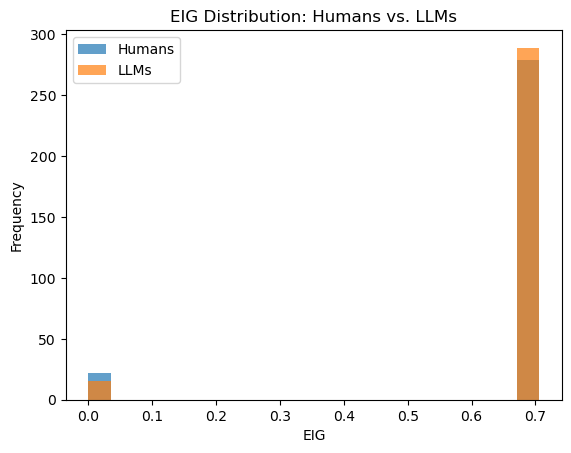

In [78]:
import matplotlib.pyplot as plt

# Separate LLM and human participants based on `subj`
# Assuming `subj` identifies humans and LLMs (adjust the condition accordingly)
human_df = df[df['subj'] < 57]  # Example: humans have `subj` IDs < 100
llm_df = df[df['subj'] >= 57]   # Example: LLMs have `subj` IDs >= 100

# Calculate average EIG for humans and LLMs
avg_eig_human = human_df['EIG'].mean()
avg_eig_llm = llm_df['EIG'].mean()

print(f"Average EIG - Humans: {avg_eig_human}")
print(f"Average EIG - LLMs: {avg_eig_llm}")

# Visualize EIG distributions
plt.hist(human_df['EIG'], alpha=0.7, label='Humans', bins=20)
plt.hist(llm_df['EIG'], alpha=0.7, label='LLMs', bins=20)
plt.title("EIG Distribution: Humans vs. LLMs")
plt.xlabel("EIG")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [80]:
# Install Hugging Face libraries
!pip install transformers datasets

# Fine-tuning script (using Python)
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments

# Load the pretrained model
model_name = "gpt-2"  # Replace with the desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Prepare the dataset (ensure you have a dataset of context-question pairs)
from datasets import Dataset

# Example: Prepare a high-EIG dataset
high_eig_df = aggregated_df[aggregated_df['EIG'] > aggregated_df['EIG'].median()]
dataset = Dataset.from_pandas(high_eig_df[['text', 'EIG']])

# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=128)

tokenized_dataset = dataset.map(tokenize, batched=True)

# Fine-tuning
training_args = TrainingArguments(
    output_dir="./fine_tuned_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
)

trainer.train()


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Error importing huggingface_hub.hf_file_system: cannot import name 'EntryNotFoundError' from 'huggingface_hub.errors' (/opt/anaconda3/envs/1016/lib/python3.10/site-packages/huggingface_hub/errors.py)


RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
cannot import name 'EntryNotFoundError' from 'huggingface_hub.errors' (/opt/anaconda3/envs/1016/lib/python3.10/site-packages/huggingface_hub/errors.py)